# Use Python Access Obj Detection LMDB

In [28]:
%matplotlib inline
from __future__ import print_function
import caffe
import lmdb
import numpy as np
from PIL import Image
import cStringIO as StringIO

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)  # in inches?

In [29]:
#lmdb_env = lmdb.open('VOC0712_test_lmdb')  # dir containing lmdb
lmdb_name = '/local/mnt/workspace/qgao/Github/caffe-ssd/examples/COCO/valminusminival2014_3ch_lmdb'
datum = caffe.proto.caffe_pb2.AnnotatedDatum() # Annotateddatum is for object detection

In [30]:
voc_label = ('background',
            'aeroplane',           'bicycle',
            'bird',            'boat',
            'bottle',            'bus',
            'car',            'cat',
            'chair',            'cow',
            'diningtable',            'dog',
            'horse',            'motorbike',
            'person',            'pottedplant',
            'sheep',            'sofa',
            'train',            'tvmonitor'
        )

https://lmdb.readthedocs.io/en/release/

The transaction provides a consistent view of the data
Within the transaction, a cursor can be created.

00000000_COCO_val2014/JPEGImages/COCO_val2014_000000296745.jpg: 640x427x3


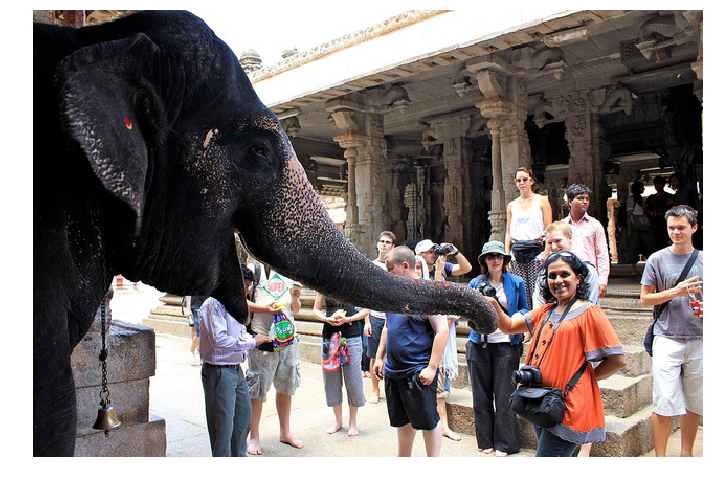

In [6]:
plt.axis('off')
n = 0
# lmdb_env = lmdb.open(lmdb_name)
# lmdb_txn = lmdb_env.begin()
# lmdb_cursor = lmdb_txn.cursor()
with lmdb.open(lmdb_name) as lmdb_env:
    with lmdb_env.begin() as lmdb_txn:
        with lmdb_txn.cursor() as lmdb_cursor:
            for k, v in lmdb_cursor:
                datum.ParseFromString(v)
                # datum has 3 fields:
                #  - type: should be zero for BBOX
                #  - datum is the image data (encoded). It has the following fields
                #    - width
                #    - height
                #    - channels
                #    - encoded
                #    - data: a str for the image data
                #  - annotation_group (see below)
                width = datum.datum.width
                height = datum.datum.height
                print('{}: {}x{}x{}'.format(k, width, height, datum.datum.channels))  

                # doesn't work for encoded image
                # img = caffe.io.datum_to_array(datum.datum)
                # plt.imshow(img)
                # decode encoded image data
                stream = StringIO.StringIO(datum.datum.data)
                image = np.uint8(Image.open(stream))  # decode encoded image to RGB 
                #image_bgr = image[...,::-1]    # RGB to BGR
                plt.imshow(image)
                break

                for per_class_anno in datum.annotation_group: # RepeatedCompositeFieldContainer
                    # per_class_anno has the following fields:
                    #  - group_label: class label for the bboxes in 'annotation' 
                    #  - annotation:  a list of bboxes all of which have the same label 'group_label'
                    for a in per_class_anno.annotation:
                        print(' {:4d} {:4d} {:4d} {:4d} {}'.format(
                              int(a.bbox.xmin * width+0.5),
                              int(a.bbox.ymin * height+0.5),
                              int(a.bbox.xmax * width+0.5),
                              int(a.bbox.ymax * height+0.5),
                              voc_label[per_class_anno.group_label])
                        )
                n += 1
                if n >= 20:    break

# Image & Bounding Box Stat's

In [35]:
def GetBboxStatFromLmdb(lmdb_name):
    seq_img_width = []
    seq_img_height =[]
    bbox_dim = {}
    for l in voc_label:
        bbox_dim[l] = ([], [], [], [])
    tgt_img_width = tgt_img_height = 320

    try:
        with lmdb.open(lmdb_name) as lmdb_env:
            with lmdb_env.begin() as lmdb_txn:
                with lmdb_txn.cursor() as lmdb_cursor:
                    for k, v in lmdb_cursor:
                        datum.ParseFromString(v)
                        width, height = datum.datum.width, datum.datum.height
                        seq_img_width.append(width)
                        seq_img_height.append(height)

                        w_scaling_factor = float(tgt_img_width) / float(width)
                        h_scaling_factor = float(tgt_img_height) / float(height)
                        for per_class_anno in datum.annotation_group: # RepeatedCompositeFieldContainer
                            # per_class_anno has the following fields:
                            #  - group_label: class label for the bboxes in 'annotation' 
                            #  - annotation:  a list of bboxes all of which have the same label 'group_label'
                            bbd = bbox_dim[ voc_label[per_class_anno.group_label] ]
                            for a in per_class_anno.annotation:
                                w = int(a.bbox.xmax * width+0.5) + 1 - int(a.bbox.xmin * width+0.5)
                                h = int(a.bbox.ymax * height+0.5) + 1 - int(a.bbox.ymin * height+0.5)
                                bbd[0].append(w)
                                bbd[1].append(h)
                                bbd[2].append(int(float(w) * w_scaling_factor + 0.5))
                                bbd[3].append(int(float(h) * h_scaling_factor + 0.5))  
        for label in bbox_dim:
            bbox_dim[label] = np.array(bbox_dim[label], dtype=np.int16)
            
        return (np.array(seq_img_width,  dtype=np.int16),
                np.array(seq_img_height, dtype=np.int16),
                bbox_dim
               )
    except Exception as e:
        import sys
        print(sys.exc_value)
        return (None,) * 3
def GetBboxDimHist(pdim, bin_size):
    hist = np.zeros(pdim.max(1)/bin_size + 1, dtype=np.uint32)
    for c in xrange(pdim.shape[1]):
        w = pdim[0, c]
        h = pdim[1, c]
        hist[h/bin_size, w/bin_size] += 1
    return hist

In [73]:
root_dir = '/local/mnt/workspace/qgao/Github/caffe-ssd/examples/'
coco28k_lmdb = root_dir + 'COCO/valminusminival2014_3ch_lmdb'
voc07_test_lmdb = root_dir + 'VOC0712/VOC0712_test_lmdb'
voc0712_trainval_lmdb = root_dir + 'VOC0712/VOC0712_trainval_lmdb'

coco_img_width, coco_img_height, coco_bbox_dim = GetBboxStatFromLmdb(coco28k_lmdb)
voctest_img_width, voctest_img_height, voctest_bbox_dim = GetBboxStatFromLmdb(voc07_test_lmdb)
voctrain_img_width, voctrain_img_height, voctrain_bbox_dim = GetBboxStatFromLmdb(voc0712_trainval_lmdb)


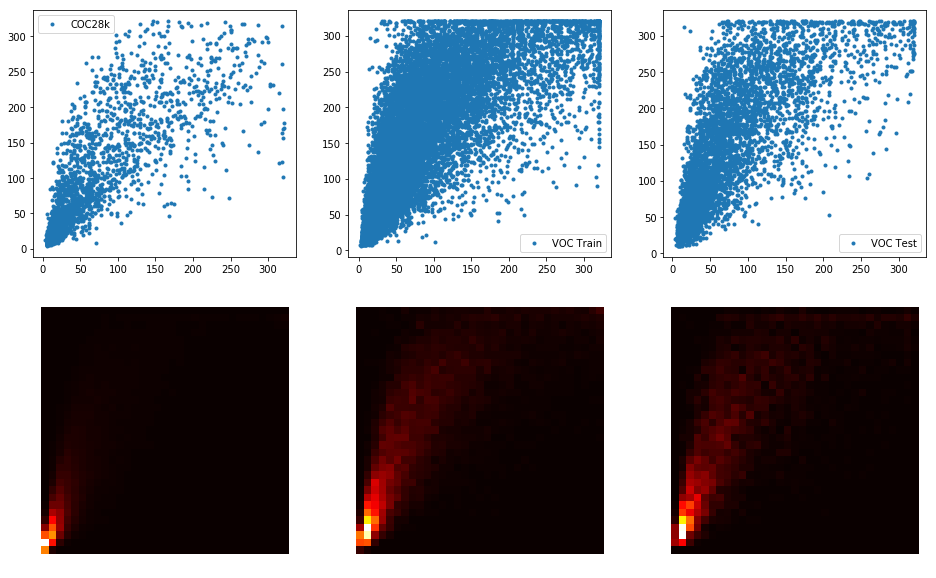

In [117]:
pylab.rcParams['figure.figsize'] = (16.0, 10.0)  # in inches?
# plt.plot(coco_img_width, coco_img_height, '.', label='COCO28k')
# plt.plot(voctrain_img_width, voctrain_img_height, '.', label='VOC Train')
# plt.plot(voctest_img_width, voctest_img_height, '.', label='VOC Test')
# plt.legend()

class_to_plot = 'horse'
plt.tight_layout()
#plt.plot(coco_bbox_dim['person'][0], coco_bbox_dim['person'][1], '.') # original dimension
bin_size = 10
plt.subplot(2,3,1)
plt.plot(coco_bbox_dim[class_to_plot][2,:], coco_bbox_dim[class_to_plot][3,:], '.', label='COC28k') # scaled dimension
plt.legend()
plt.subplot(2,3,4)
hist=GetBboxDimHist(coco_bbox_dim['person'][2:4,:], bin_size)
plt.axis('off')
plt.imshow(np.flipud(hist), cmap='hot', interpolation='nearest') # cmap='hot'

plt.subplot(2,3,2)
plt.plot(voctrain_bbox_dim['person'][2,:], voctrain_bbox_dim['person'][3,:], '.', label='VOC Train') # scaled dimension
plt.legend()
plt.subplot(2,3,5)
hist=GetBboxDimHist(voctrain_bbox_dim['person'][2:4,:], bin_size)
plt.axis('off')
plt.imshow(np.flipud(hist), cmap='hot', interpolation='nearest') # cmap='hot'

plt.subplot(2,3,3)
plt.plot(voctest_bbox_dim['person'][2,:], voctest_bbox_dim['person'][3,:], '.', label='VOC Test') # scaled dimension
plt.legend()
plt.subplot(2,3,6)
hist=GetBboxDimHist(voctest_bbox_dim['person'][2:4,:], bin_size)
plt.axis('off')
plt.imshow(np.flipud(hist), cmap='hot', interpolation='nearest') # cmap='hot'
